<center>
<h1><b>Categorizzazione dei video di Youtube</b></h1>
<h3><i>Analisi del testo - classificazione multiclasse</i></h3>
<p>Antonio Pelusi</p>
<p>Matricola: 182267</p>
<p>257241@studenti.unimore.it</p>
</center>

# Indice

1. **[Obiettivo](#1---obiettivo)**

2. **[Progettazione](#2---progettazione)**

3. **[Inizializzazione](#3---inizializzazione)**

4. **[Raccolta dati](#4---raccolta-dei-dati)**

5. **[Pulizia del dataset](#5---pulizia-del-dataset)**

6. **[Pulizia del testo](#6---pulizia-del-testo)**

7. **[Tokenizzazione](#7---tokenizzazione)**

8. **[Analisi esplorativa](#8---analisi-esplorativa)**

9. **[Train set e Test set](#9---train-set-e-test-set)**

10. **[Training](#10---training)**

11. **[Test](#11---test)**

12. **[Analisi dei risultati](#12---analisi-dei-risultati)**

# 1 - Obiettivo

L'obiettivo del seguente progetto è quello di sviluppare un modello di text mining capace di assegnare correttamente una categoria ad un video Youtube.

Si tratta quindi di un problema di classificazione multi-classe.

# 2 - Progettazione

Essendo un modello di text mining, le uniche risorse testuali che un video su Youtube possiede sono titolo e descrizione.

Ogni video potrà essere classificato in una delle seguenti 9 categorie:
- **travel**
- **science and technology**
- **food**
- **manufacturing**
- **history**
- **art and music**
- **nature**
- **sports**
- **adventure**

L'intero processo sarà diviso nelle seguenti macro aree:
- **Raccolta dei dati**: per questo progetto verrà utilizzato un dataset contenente ~30k records, ciascuno contenente le informazioni di un video di Youtube, tra cui titolo, descrizione e la categoria
- **Pulizia del dataset**: consiste nella rimozione dei records che hanno qualche informazione mancante. infatti questi record avrebbero una influenza negativa nella fase di training, poiché potrebbero dare informazioni sbagliate
- **Pulizia del testo**: questa fase applicherà alle informazioni grezze (titolo e descrizione) le seguenti modifiche:
    - unione dei titoli e delle descrizioni (al fine di avere un'unica fonte di informazioni)
    - Rimozione codice html, urls, caratteri speciali e stopwords
    - Stemming del testo (processo di riduzione della forma flessa di una parola alla sua forma radice, detta *tema*)
- **Tokenizzazione**: consiste nella divisione del testo grezzo in unità più piccole, detti *token*
- **Analisi esplorativa**: in questa fase verrà studiato approssimativamente il dataset e la sua struttura. Verranno inoltre scelti i metodi che dovranno essere utilizzati nella fase di training, tenendo conto sia dell'obiettivo che del dataset
- **Train set e Test set**: a questo punto il dataset verrà diviso in due parti: una parte verrà utilizzata per la fase di training, l'altra per la fase di test, in cui verrà calcolata l'accuratezza del modello
- **Training**: in questa fase avverrà l'addestramento del modello con i dati del training set con il metodo scelto nella fase di analisi esplorativa
- **Test**: a questo punto sarà possibile valutare l'accuratezza del modello, calcolando in percentuale quanti errori commette sul test set
- **Analisi dei risultati**: con l'accuratezza ottenuta dalla fase di test, sarà possibile trarre delle conclusioni, valutando se i risultati soddisfano gli obiettivi previsti, o eventualmente considerare metodi alternativi di training o di pulizia del testo

# 3 - Inizializzazione

Importazione librerie necessarie:

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import nltk
import re
import random
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from itertools import chain
 
import warnings
warnings.simplefilter(action='ignore')

Importazione del dataset:

In [3]:
yt = pd.read_csv('youtube-videos.csv')
print(yt.shape)
yt.head(10)

(29245, 7)


,Unnamed: 0.1,Category,Description,Title,Unnamed: 0,Video Id,file
0,0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,0,i9E_Blai8vk,Collected_data_raw1.csv
1,1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,1,UBvJKs9eW3I,Collected_data_raw1.csv
2,2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,2,jeIQ_Z35HZ4,Collected_data_raw1.csv
3,3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",3,EthqIhPtd2I,Collected_data_raw1.csv
4,4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,4,X0F0Dh8ut3U,Collected_data_raw1.csv
5,5,travel,Follow along a travel day in my life!! LINKS: ...,"TRAVEL DAY VLOG: Airport Essentials, What&#39;...",5,USGN-aTzlG4,Collected_data_raw1.csv
6,6,travel,i still cant believe they had philz on the pla...,just a travel vlog. nothing special.,6,wfIWTD30gCw,Collected_data_raw1.csv
7,7,travel,This past March of 2020 we visited The Maldive...,LUXURY MALDIVES EXPERIENCE | TRAVEL VLOG,7,FaeQtn3-h4w,Collected_data_raw1.csv
8,8,travel,INSTA: https://instagram.com/annaheid?igshid=x...,travel vlog: airport at 4 am on CHRISTMAS!!,8,DD-Znv9vV5s,Collected_data_raw1.csv
9,9,travel,We are selecting one person who makes a purcha...,Traveling to the Happiest Country in the World!!,9,Qmi-Xwq-MEc,Collected_data_raw1.csv


# 4 - Raccolta dei dati

Il dataset è stato scaricato dal sito [kaggle.com](https://www.kaggle.com/) ed è consultabile e scaricabile **[QUI](https://www.kaggle.com/datasets/aashishbidap/youtube-api-data-for-text-categorization)**.

Come da traccia del progetto, è stato scelto appositamente un dataset che non abbia alcun notebook o discussione scritto su di esso.

# 5 - Pulizia del dataset

Rimuovo le colonne superflue alla classificazione per questioni di efficienza:

In [4]:
del yt['file']
del yt['Unnamed: 0']
del yt['Unnamed: 0.1']

print(yt.shape)
yt.head(10)

(29245, 4)


,Category,Description,Title,Video Id
0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,i9E_Blai8vk
1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,UBvJKs9eW3I
2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,jeIQ_Z35HZ4
3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",EthqIhPtd2I
4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,X0F0Dh8ut3U
5,travel,Follow along a travel day in my life!! LINKS: ...,"TRAVEL DAY VLOG: Airport Essentials, What&#39;...",USGN-aTzlG4
6,travel,i still cant believe they had philz on the pla...,just a travel vlog. nothing special.,wfIWTD30gCw
7,travel,This past March of 2020 we visited The Maldive...,LUXURY MALDIVES EXPERIENCE | TRAVEL VLOG,FaeQtn3-h4w
8,travel,INSTA: https://instagram.com/annaheid?igshid=x...,travel vlog: airport at 4 am on CHRISTMAS!!,DD-Znv9vV5s
9,travel,We are selecting one person who makes a purcha...,Traveling to the Happiest Country in the World!!,Qmi-Xwq-MEc


Controllo se il dataset è completo:

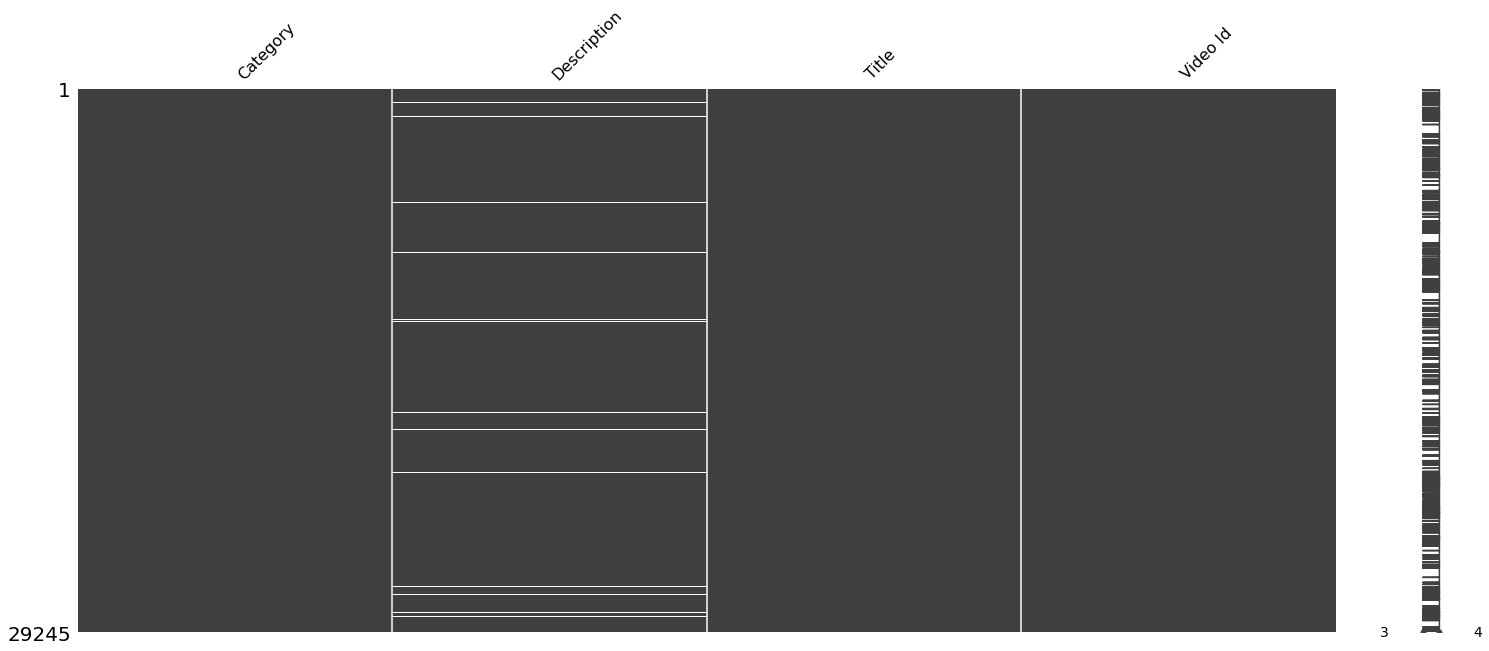

In [5]:
msno.matrix(yt);

È possibile notare che vi sono video che non presentano la descrizione. Poiché il campo della descrizione è necessario, si può procedere con la rimozione di tali records:

In [6]:
yt.dropna(axis=0, how='any',inplace=True)

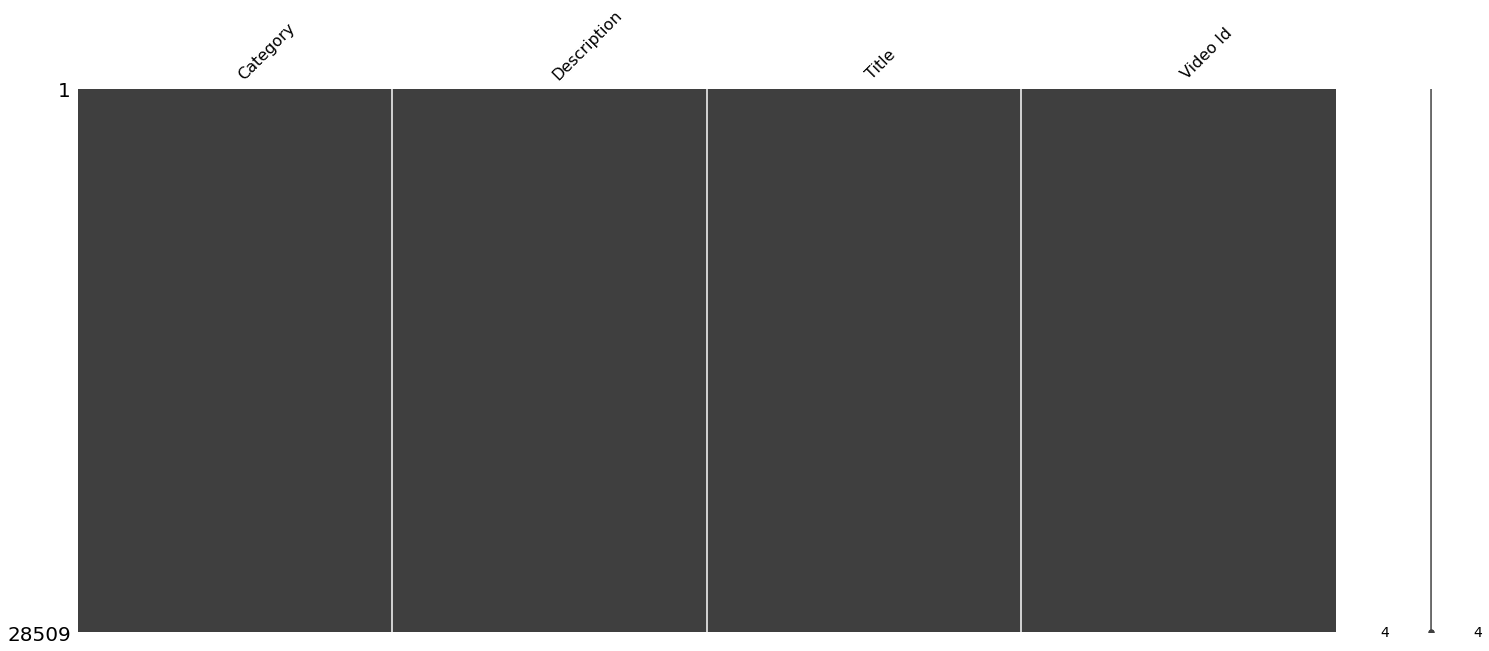

In [7]:
msno.matrix(yt);

# 6 - Pulizia del testo

Unisco le colonne Title e Description in una nuova colonna chiamata Tokens:

In [8]:
yt['Tokens'] = yt['Title'] + ' ' + yt['Description']

del yt['Title']
del yt['Description']

Rimozione codice html, urls, caratteri speciali e stopwords:

In [9]:
def remove_html(text):
    bs = BeautifulSoup(text, "html.parser")
    return bs.get_text()

def remove_urls(text):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_stopwords(text, is_lower_case=False):
    stopword_list = nltk.corpus.stopwords.words('english')
    tokenizer = ToktokTokenizer()

    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

yt['Tokens'] = yt['Tokens'].apply(remove_html)
yt['Tokens'] = yt['Tokens'].apply(remove_urls)
yt['Tokens'] = yt['Tokens'].apply(remove_special_characters)
yt['Tokens'] = yt['Tokens'].apply(remove_stopwords)

Stemming del testo:

In [ ]:
def stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

yt['Tokens'] = yt['Tokens'].apply(stemmer)

# 7 - Tokenizzazione

In [ ]:
yt['Tokens'] = yt['Tokens'].apply(nltk.word_tokenize)

Il dataset è pronto alla fase di analisi esplorativa.

# 8 - Analisi esplorativa

Struttura:

In [ ]:
print('Numero di records:', yt.shape[0])

In [ ]:
yt.head()

Controllo categorie:

In [ ]:
categories = yt['Category'].unique()

print('Numero di categorie:', categories.size, '\n')

for i in categories:
    print('-', i)

Confronto tra i video per categoria:

In [ ]:
c = yt['Category'].value_counts()

plt.figure(figsize=(15,5))
plt.bar(c.index, c.values, color = 'darkgrey')
plt.xlabel('Categoria')
plt.ylabel('Numero di video')
plt.xticks(rotation=15)
plt.show();

Numero di token totali:

In [ ]:
print(sum([len(i) for i in yt['Tokens']]))

# 9 - Train set e Test set

Procedo con il creare un sistema che permetta di dividere il dataset tra train set e test set usando una percentuale inserita dall'utente:

In [ ]:
# - - - - - - - - - - - - - - #
train_set_percentage = 70
# - - - - - - - - - - - - - - #

test_set_percentage = 100-train_set_percentage

total_size = yt.shape[0]

train_set_size = total_size//100*train_set_percentage

In questo modo, cambiando il valore della variabile **train_set_percentage** è possibile cambiare la percentuale di dataset che verrà dedicata al train set, e la restante verrà utilizzata come test set.

A questo punto è possibile creare il **feature_set** che conterrà le informazioni relative alle parole contenute in ciascun titolo/descrizione dei video.

Il **feature_set** verrà poi diviso in **train_set** e **test_set** a seconda del rapporto percentuale inserito dall'utente:

In [ ]:
docs = [(yt['Tokens'].to_list()[i], yt['Category'].to_list()[i]) for i in range(len(yt))]

random.shuffle(docs)

allWords = [word.lower() for doc in docs for word in doc[0]]

vocabulary = [w[0] for w in nltk.FreqDist(allWords).most_common(3000)]

def docFeatures(document):
    docWords = set(document)
    features = {}
    for word in vocabulary:
        features['contains({})'.format(word)] = (word in docWords)
    return features

feature_sets = [(docFeatures(d), c) for (d,c) in docs]

train_set = feature_sets[:train_set_size]
test_set = feature_sets[train_set_size:]

Controllo le dimensioni di **train_set** e **test_set**:

In [ ]:
print('Dimensione totale del dataset:', total_size, f'({train_set_percentage+test_set_percentage}%)')
print('Dimensione train set:', len(train_set), f'({train_set_percentage}%)')
print('Dimensione test set:', len(test_set), f'({test_set_percentage}%)')

# 10 - Training

In questa fase di testing verrà utilizzato il metodo *Naive Bayes*, implementato dalla libreria nltk:

In [ ]:
# classifier = nltk.NaiveBayesClassifier.train(train_set)

# 11 - Test

In [ ]:
# print(str('{0:.3g}'.format(nltk.classify.accuracy(classifier, test_set)*100)) + '%')

Il valore ottenuto rappresenta la percentuale di accuratezza calcolata testando il modello istruito sul **train_set** ed eseguito sul **test_set**.

Visualizzo ora le 10 informazioni più utili che il modello ha imparato autonomamente dai dati:

In [ ]:
# classifier.show_most_informative_features(10)

In [ ]:
d = {'3d':1151, 'archaeolog':1148, 'food':941, 'delici':668, 'print':640,  'ancient':560, 'sport':485, 'deadliest':478, 'robot':399, 'archaeologist':362}
plt.figure(figsize=(15,5))
plt.bar(d.keys(), d.values(), color = 'darkgrey')
plt.xlabel('Categoria')
plt.ylabel('Numero di video')
plt.xticks(rotation=15)
plt.show();

# 12 - Analisi dei risultati

Effettuando una singola run di training, si ottiene un'accuratezza che varia tra l'88% e l'89%.

Effettuando più run consecutive (effettuando lo shuffle dei documenti di volta in volta), si ottiene sempre un'accuratezza varia tra l'88% e l'89%.

Per mantenere ragionevoli i tempi di esecuzione di questo notebook, nel codice è presente solo una singola run di training a scopo dimostrativo, poiché ogni singola run impiega ~6 minuti per le fasi di preparazione dati, training e testing.

Confrontando l'accuratezza di una singola run di training rispetto a più run casuali combinate, le percentuali restano uguali.

Di seguito una tabella contenente le percentuali di accuratezza a seconda delle diverse combinazioni di training_set/test_set testate:

|train set size (%)|test set size (%)|accuracy|
|:-|:-|:-|
|14250 (50%)|14259 (50%)|88.4%|
|17100 (60%)|11409 (40%)|88.5%|
|19950 (70%)|8559 (30%)|88.5%|
|22800 (80%)|5709 (20%)|88.7%|
|25650 (90%)|2859 (10%)|88.9%|

Le percentuali risultano stabili sia al variare della combinazione di training_set/test_set che all'aumentare delle run casuali.

È possibile dare una spiegazione precisa a questo fenomeno:
- il dataset è abbastanza grande da raccogliere sufficienti token per l'addestramento, e run multiple su diverse porzioni del dataset non aggiungono informazioni utili all'addestramento
- poiché sono state effettuate operazioni di pulizia e correzione del dataset (tra cui lo stemming dei token), i diversi records avranno spesso molteplici token in comune

I risultati ottenuti soddisfano pienamente l'obiettivo previsto.

Nonostante il fatto che spesso i titoli e le descrizioni dei video su Youtube contengono poche informazioni riguardanti il genere dei video (dato che Youtube stessa permette la condivisione di contenuti senza un processo di valutazione qualitativo), il modello riesce comunque a classificare correttamente buona parte dei video processati.



# TODO: provare nuovi metodi

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [ ]:
allTarget = [None for i in range(28509)]

j = 0
for i in yt['Category'].to_list():
    if i == 'travel':
        allTarget[j] = 0
    if i == 'science and technology':
        allTarget[j] = 1
    if i == 'food':
        allTarget[j] = 2
    if i == 'manufacturing':
        allTarget[j] = 3
    if i == 'history':
        allTarget[j] = 4
    if i == 'art and music':
        allTarget[j] = 5
    if i == 'nature':
        allTarget[j] = 6
    if i == 'sports':
        allTarget[j] = 7
    if i == 'adventure':
        allTarget[j] = 8
    j+=1

categories = list(set(yt['Category']))

train_s = allWords[:400000]
test_s = allWords[400000:]

train_t = allTarget[:400000]
test_t = allTarget[400000:]

print('Dimensione train set:', len(train_s))
print('Dimensione test set:', len(test_s))

print(len(allTarget))

In [ ]:
# Building a pipeline and training classifier
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
#text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
text_clf.fit(train_s, allTarget)

# Evaluating the performance on the test set
predicted = text_clf.predict(test_s)
print(metrics.classification_report(test_t, predicted, target_names=categories))

# Cross-validation
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#scores = cross_val_score(text_clf, twenty_train.data, twenty_train.target, cv=cv)
#print (scores)

# Parameter tuning using grid search (and cross-validation)
#parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
#gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1)
#gs_clf = gs_clf.fit(twenty_train.data[:400], twenty_train.target[:400])
#predicted = gs_clf.predict(twenty_test.data)
#print(metrics.classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))

In [ ]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']      
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Building a pipeline and training classifier
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
#text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
text_clf.fit(twenty_train.data, twenty_train.target)

# Evaluating the performance on the test set
predicted = text_clf.predict(twenty_test.data)
print(metrics.classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))

print('Dimensione categories:', len(categories))
print('Dimensione train set:', len(twenty_train.data))
print('Dimensione test set:', len(twenty_test.data))
print('Dimensione train target:', len(twenty_train.target))
print('Dimensione train target:', len(twenty_test.target))


---

In [ ]:
x = [i for i in yt['Tokens'].to_list()]



print(x)

y = [None for i in range(28509)]

j = 0
for i in yt['Category'].to_list():
    if i == 'travel':
        y[j] = 0
    if i == 'science and technology':
        y[j] = 1
    if i == 'food':
        y[j] = 2
    if i == 'manufacturing':
        y[j] = 3
    if i == 'history':
        y[j] = 4
    if i == 'art and music':
        y[j] = 5
    if i == 'nature':
        y[j] = 6
    if i == 'sports':
        y[j] = 7
    if i == 'adventure':
        y[j] = 8
    j+=1


print(len(x))
print(len(y))

#print(x[1000])
#print(y[1000])


NameError: name 'yt' is not defined